In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'src/')
import acs5
import nyserda_acs
import prices
import project_sunroof
import nyserda
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import recall_score

#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/


%matplotlib inline

In [50]:
raw_data = nyserda_acs.merging_data()
raw_data=raw_data[raw_data['households']>0]

In [3]:
raw_data.shape

(4831, 157)

## Weights

In [4]:
#Duplicate positive rows
duplic = raw_data.loc[raw_data['Project_yes']==1,:]
duplic.loc[:,'Project_yes'] =0
duplic.loc[:,'Duplicate'] = 'Yes'
duplic.loc[:,'weight'] = (duplic.loc[:,'households']-duplic.loc[:,'Project_Number'])
duplic=duplic[duplic['weight']>0]
#Creating weights in old data
raw_data.loc[raw_data['Project_yes'] == 1, 'weight'] = raw_data['Project_Number']
raw_data.loc[raw_data['Project_yes'] == 0, 'weight'] = raw_data['households']
raw_data['Duplicate']='No'
#Merging data 
#Concatenating
all_data = raw_data.append(duplic, ignore_index=True)

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [5]:
all_data.shape

(6022, 159)

In [ ]:
raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

In [ ]:
raw_data['Project_Number'].sum(axis=None, skipna=True, level=None, numeric_only=None)/raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

In [6]:
# Imputing missing values
all_data.loc[all_data['yearly_sunlight_kwh_total'].isnull(), 'yearly_sunlight_kwh_total'] = 0
all_data.loc[all_data['percent_qualified'].isnull(), 'percent_qualified'] = 200
all_data.loc[all_data['Avg_hh_size'].isnull(), 'Avg_hh_size']=np.mean(all_data.Avg_hh_size)
all_data.loc[all_data['median_rooms'].isnull(), 'median_rooms']=5.320409

## Columns

In [7]:
all_columns = list(all_data.columns)

In [8]:
len(all_columns)

159

In [9]:
acs= acs5.Get_census_data()
acs_data = acs.get_acs_all()

In [10]:
acs_percent_variables = acs.education_percent + acs.other_households + acs.units_percent + acs.heating_percent + acs.rooms_percent

## More complex model

In [11]:
acs_percent_variables.append('Project_yes')
acs_percent_variables.append('Mean_price')
acs_percent_variables.append('Var_price')
acs_percent_variables.append('percent_qualified')
acs_percent_variables.append('yearly_sunlight_kwh_total')
acs_percent_variables.append('weight')
acs_percent_variables.append('Duplicate')
df=all_data[acs_percent_variables]
df.describe()

,Percent_Less_9th,Percent_12th_no_dip,Percent_HighSchool,Percent_Some_college,Percent_Associate,Percent_Bachelors,Percent_Graduate,Percent_more_than_hs,Avg_hh_size,Median_age,...,Percent_7_rooms,Percent_8_rooms,Percent_9_more_rooms,median_rooms,Project_yes,Mean_price,Var_price,percent_qualified,yearly_sunlight_kwh_total,weight
count,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6015.000000,...,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6.022000e+03,6022.000000
mean,0.061967,0.077948,0.279996,0.166751,0.089023,0.183827,0.140489,0.580089,2.691910,39.544472,...,0.112125,0.082156,0.101986,5.320409,0.198273,28.992411,209.900863,109.287977,7.140375e+06,1205.975590
std,0.063333,0.054221,0.100521,0.053400,0.041828,0.092332,0.105947,0.160649,0.531434,7.017340,...,0.079107,0.068423,0.091860,1.205090,0.398732,4.220938,109.370253,57.698362,1.137619e+07,908.509944
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.030000,11.300000,...,0.000000,0.000000,0.000000,1.300000,0.000000,18.309167,95.470254,21.212121,0.000000e+00,1.000000
25%,0.019415,0.037299,0.218787,0.133193,0.058894,0.114487,0.063992,0.462997,2.350000,34.700000,...,0.043462,0.023406,0.033550,4.300000,0.000000,25.463787,163.361579,70.092198,0.000000e+00,575.000000
50%,0.038274,0.067073,0.286477,0.167410,0.086880,0.169615,0.111104,0.572390,2.610000,40.300000,...,0.114309,0.071972,0.085869,5.500000,0.000000,30.932676,188.915562,81.747944,3.374421e+06,1176.500000
75%,0.082944,0.105995,0.350874,0.198676,0.116209,0.238077,0.187383,0.688009,2.980000,44.400000,...,0.164579,0.123021,0.144573,6.200000,0.000000,30.932676,195.928370,200.000000,8.996928e+06,1717.750000
max,0.445956,0.400000,0.793103,1.000000,1.000000,1.000000,1.000000,1.000000,6.270000,82.000000,...,1.000000,0.809524,1.000000,8.500000,1.000000,35.571604,477.108098,200.000000,1.720241e+08,12305.000000


In [12]:
df.shape

(6022, 46)

In [13]:
df1=df.dropna()
y=df1['Project_yes']
weights=df1['weight']
features=df1.drop(['Project_yes', 'weight','Duplicate'], axis=1)

In [14]:
features.shape

(6015, 43)

In [15]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

# define scoring function 
def custom_auc(ground_truth, predictions):
    # I need only one column of predictions["0" and "1"]. You can get an error here
    # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

In [16]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(features, y, weights, test_size=0.3, random_state=42)

In [ ]:
model = GradientBoostingClassifier()
search = GridSearchCV(model, param_grid = {'n_estimators' :[500, 1000, 5000], 'subsample' :[0.8],
                                           'max_depth': [2,3,4,5], 'learning_rate' : [0.1, 0.01, 0.001]}, 
                     scoring=my_auc, fit_params={'sample_weight': weights_train}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [ ]:
fitted = search.fit(X_train,y_train)

In [ ]:
fitted.score(X_test, y_test)

In [ ]:
recall_score(y_test, fitted.predict(X_test))

In [ ]:
fitted.best_params_

In [ ]:
# Adding results to orginal Data Frames
df1['result']=fitted.predict_proba(features)[:,1]

In [ ]:
np.mean(df1['result'])

## ROC Curve

In [26]:
model = GradientBoostingClassifier(learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=0.8)

In [27]:
fitted = model.fit(X_train, y_train, sample_weight=weights_train)

In [48]:
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, weigths_test)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
fig.savefig('roc_sep8.png')
plt.show()


NameError: name 'weigths_test' is not defined

## Feature importance

In [ ]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.5)

In [ ]:
fitted = model.fit(X_train, y_train, sample_weight=weights_train)

In [ ]:
fitted.feature_importances_

In [ ]:
fitted.feature_importances_
feature_importances = 100*fitted.feature_importances_ / np.sum(fitted.feature_importances_)
feature_importances, feature_names, feature_idxs = zip(*sorted(zip(feature_importances, list(features.columns), range(len(features.columns)))))

width = 0.8

idx = np.arange(len(features.columns))

fig, ax = plt.subplots(figsize=(10,12))
ax.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names, fontsize=8)

ax.set_title("Feature Importances in Gradient Booster")
ax.set_xlabel('Relative Importance of Feature', fontsize=10)
ax.set_ylabel('Feature Name', fontsize=14)
fig.savefig('feat_imp_sep8.png')

## Boosting Stages

In [29]:
N_ESTIMATORS =10000

In [30]:
model = GradientBoostingClassifier(n_estimators=N_ESTIMATORS,max_depth=2, learning_rate=0.001, subsample=0.8)
model.fit(X_train, y_train, sample_weight=weights_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10000, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [45]:
def log_loss(y, y_hat, weights):
    return (1.0 / y.shape[0]) * np.sum(weights*(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)))

In [46]:
train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict_proba(X_train)):
    train_score[i] = -log_loss(y_train, y_pred[:, 1], weights_train)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict_proba(X_test)):
    test_score[i] = -log_loss(y_test, y_pred[:, 1], weights_test)

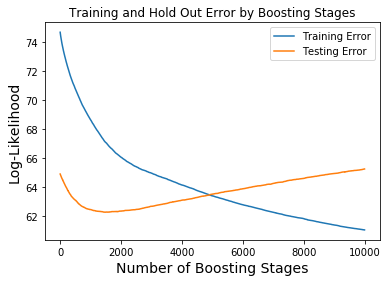

In [47]:
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Log-Likelihood', fontsize=14)
plt.legend(loc="upper right")
#plt.ylim([1.38, 1.39])

plt.savefig('training-and-testing-error.png', bbox_inches='tight')

In [ ]:
model.staged_predict?